<a href="https://colab.research.google.com/github/haripatel07/Smart_Agriculture_System/blob/main/plant_disease_detection_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the Packages

In [2]:
import numpy as np  # Linear algebra
import pandas as pd  # Data processing, CSV file I/O
import seaborn as sns
import sys
import os
import keras
from numpy import load
import matplotlib.pyplot as plt  # Fixed matplotlib import
from sklearn.model_selection import train_test_split
from keras import backend
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import SGD
from tensorflow.keras.applications import VGG16  # Fixed import
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array  # Fixed imports


# Image Preprocessing

In [3]:
# plant_village = Dataset("/kaggle/input/plant-village-dataset/PlantVillageDataset/PlantVillage/PlantVillage")

import kagglehub

# Download latest version
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

100%|██████████| 658M/658M [00:30<00:00, 22.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1


In [4]:
import os
import shutil
import random

# Source dataset path
dataset_path = "/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/PlantVillage"
base_dir = "/root/plant_village_split"

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)

# Split dataset
split_ratio = {"train": 0.7, "val": 0.15, "test": 0.15}

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)

    if not os.path.isdir(category_path):
        continue  # Skip non-directory files

    images = os.listdir(category_path)
    random.shuffle(images)

    train_split = int(split_ratio["train"] * len(images))
    val_split = int(split_ratio["val"] * len(images))

    sets = {
        "train": images[:train_split],
        "val": images[train_split:train_split + val_split],
        "test": images[train_split + val_split:]
    }

    for set_type, image_list in sets.items():
        set_dir = os.path.join(base_dir, set_type, category)
        os.makedirs(set_dir, exist_ok=True)

        for img in image_list:
            src_path = os.path.join(category_path, img)
            dest_path = os.path.join(set_dir, img)
            shutil.copy(src_path, dest_path)

print("Dataset split completed.")


Dataset split completed.


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

traindir = "/root/plant_village_split/train"
validdir = "/root/plant_village_split/val"
testdir = "/root/plant_village_split/test"

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 128

training_set = train_datagen.flow_from_directory(traindir,
                                                 target_size=(224, 224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

valid_set = valid_datagen.flow_from_directory(validdir,
                                              target_size=(224, 224),
                                              batch_size=batch_size,
                                              class_mode='categorical')


Found 14440 images belonging to 15 classes.
Found 3089 images belonging to 15 classes.


In [6]:
class_dict = training_set.class_indices
print(class_dict)

{'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}


In [7]:
li = list(class_dict.keys())
print(li)

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [8]:
train_num = training_set.samples
valid_num = valid_set.samples

# Model Preparation

In [9]:
base_model=VGG16(include_top=False,input_shape=(224,224,3))
base_model.trainable=False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [10]:
classifier=keras.models.Sequential()
classifier.add(base_model)
classifier.add(Flatten())
classifier.add(Dense(15,activation='softmax'))
classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 15)                  │         376,335 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,091,023 (57.57 MB)

 Trainable params: 376,335 (1.44 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
classifier.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
#fitting images to CNN
history = classifier.fit(training_set,
                         steps_per_epoch=train_num//batch_size,
                         validation_data=valid_set,
                         epochs=10,
                         validation_steps=valid_num//batch_size,
                         )
#saving model
#filepath="Mymodel.hdf5"
#model.save(filepath)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.5156 - loss: 1.7423 - val_accuracy: 0.8291 - val_loss: 0.5516
Epoch 2/10
  1/112 ━━━━━━━━━━━━━━━━━━━━ 1:00 545ms/step - accuracy: 0.8203 - loss: 0.5609

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - accuracy: 0.8203 - loss: 0.5609 - val_accuracy: 0.8223 - val_loss: 0.5817
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.8020 - loss: 0.6077 - val_accuracy: 0.8574 - val_loss: 0.4513
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 180ms/step - accuracy: 0.8203 - loss: 0.5266 - val_accuracy: 0.8529 - val_loss: 0.4538
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.8464 - loss: 0.4801 - val_accuracy: 0.8633 - val_loss: 0.4203
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - accuracy: 0.8203 - loss: 0.6303 - val_accuracy: 0.8682 - val_loss: 0.4092
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.8598 - loss: 0.4223 - val_accuracy: 0.8737 - val_loss: 0.3942
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 123ms/step - accuracy: 0.8359 - loss: 0.4314 - val_accuracy: 0.8743 - val_loss: 0.3881
Epoch 9/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.8736 - loss: 0.3779 - val_accurac

In [13]:
#Saving our model
filepath="Mymodel.h5"
classifier.save(filepath)

Visualizing the Accuracy

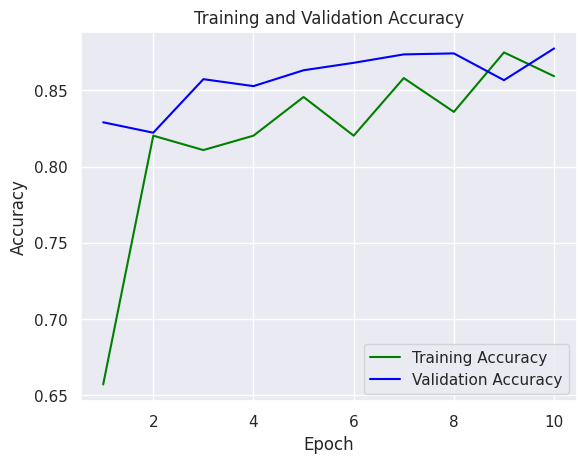

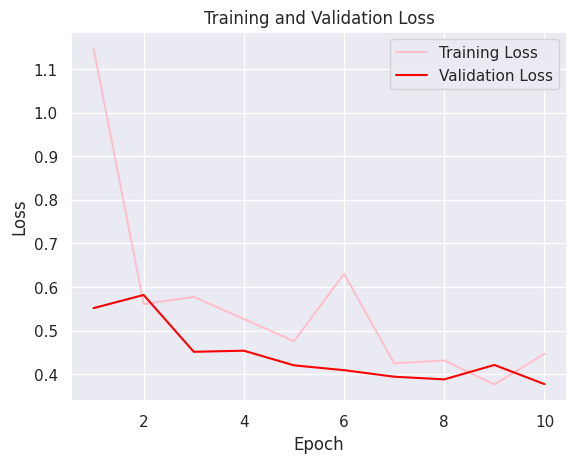

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Following is our prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


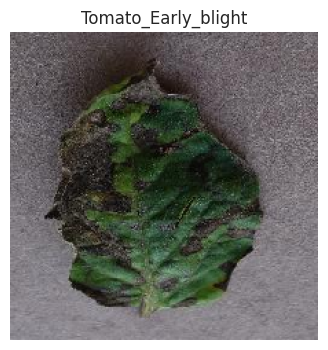

In [32]:
# predicting an image
from tensorflow.keras.preprocessing import image
import numpy as np
image_path = "06339fe1-154f-4bcb-be91-a29e86e25929___RS_Erly.B 7440.jpg"
new_img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

print("Following is our prediction:")
prediction = classifier.predict(img)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]

#ploting image with predicted class name
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()

In [25]:
from google.colab import files
uploaded = files.upload()  # This will allow you to upload the image


Saving 06339fe1-154f-4bcb-be91-a29e86e25929___RS_Erly.B 7440.jpg to 06339fe1-154f-4bcb-be91-a29e86e25929___RS_Erly.B 7440.jpg


In [26]:
import os

# List the files in the current working directory (where the uploaded file is)
uploaded_files = os.listdir()
print(uploaded_files)


['.config', 'Mymodel.h5', '06339fe1-154f-4bcb-be91-a29e86e25929___RS_Erly.B 7440.jpg', 'sample_data']


Found 3109 images belonging to 15 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3109/3109 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step
Normalized confusion matrix


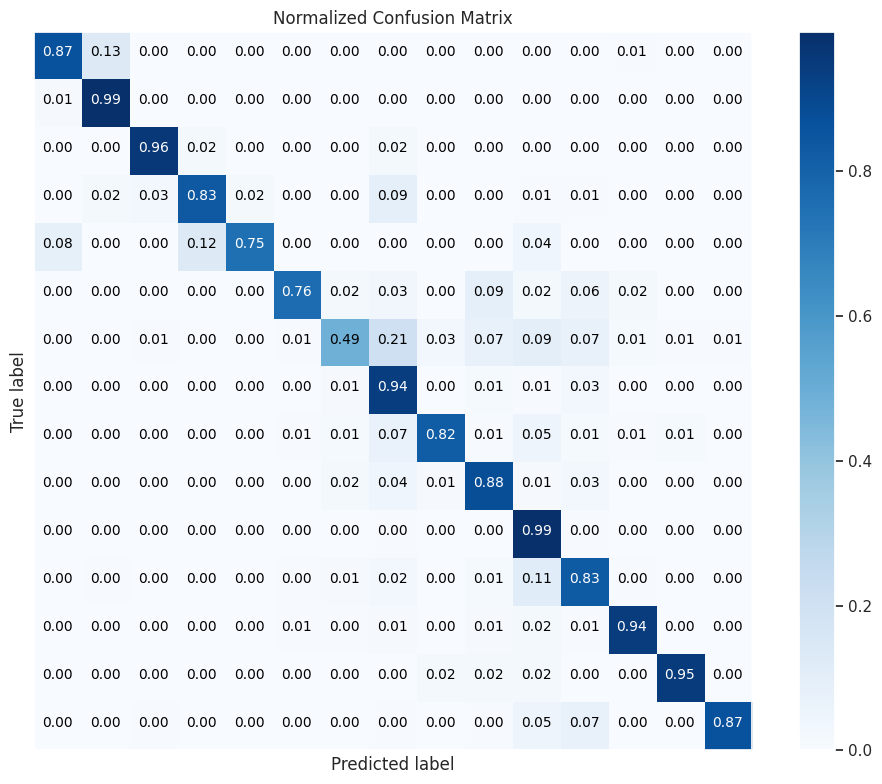

In [36]:
from keras.models import load_model
model = load_model('Mymodel.h5')
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          fontsize=10):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])

    fmt = '.0f' if not normalize else '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=fontsize)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Predict labels for images in the test directory
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(testdir,
                                            target_size=(224, 224),
                                            batch_size=1,
                                            class_mode='categorical',
                                            shuffle=False)

test_num = test_set.samples
true_labels = test_set.classes

predictions = model.predict(test_set, steps=test_num)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, np.argmax(predictions, axis=1))

# Plot confusion matrix without labels
plt.figure(figsize=(10, 8))
plot_confusion_matrix(conf_matrix, classes=test_set.class_indices.keys(), normalize=True,
                      title='Normalized Confusion Matrix')
plt.show()


Found 3109 images belonging to 15 classes.
   9/3109 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3109/3109 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step
Confusion matrix, without normalization


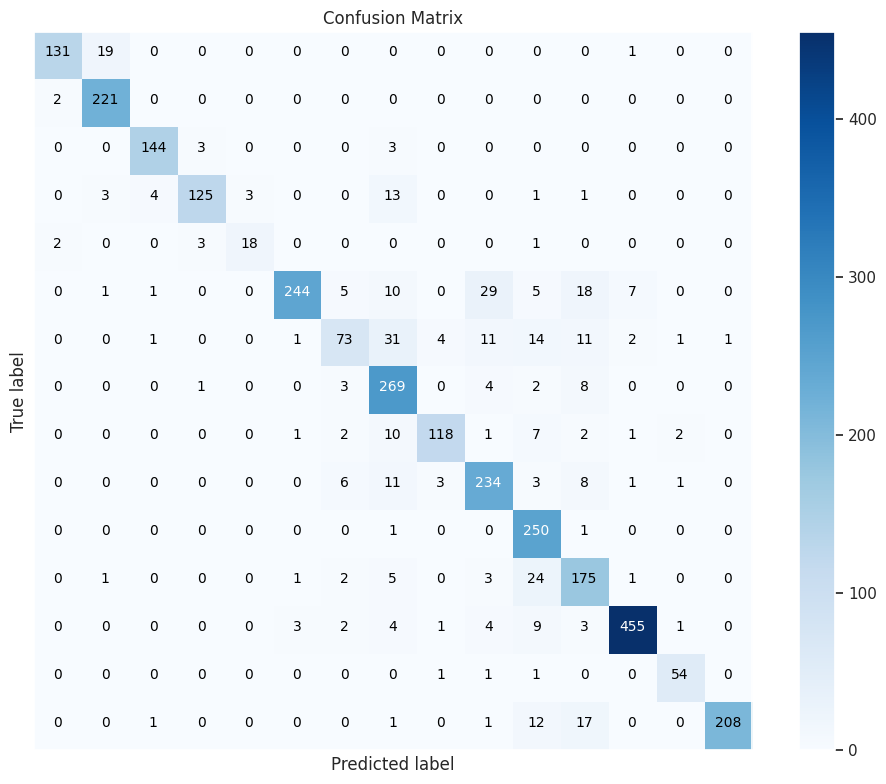

In [37]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          fontsize=10):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])

    fmt = '.0f' if not normalize else '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=fontsize)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Predict labels for images in the test directory
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(testdir,
                                            target_size=(224, 224),
                                            batch_size=1,
                                            class_mode='categorical',
                                            shuffle=False)

test_num = test_set.samples
true_labels = test_set.classes

predictions = model.predict(test_set, steps=test_num)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, np.argmax(predictions, axis=1))

# Plot confusion matrix without labels
plt.figure(figsize=(10, 8))
plot_confusion_matrix(conf_matrix, classes=test_set.class_indices.keys(),
                      title='Confusion Matrix')
plt.show()


In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, np.argmax(predictions, axis=1))
precision = precision_score(true_labels, np.argmax(predictions, axis=1), average='weighted')
recall = recall_score(true_labels, np.argmax(predictions, axis=1), average='weighted')
f1 = f1_score(true_labels, np.argmax(predictions, axis=1), average='weighted')

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)




Accuracy: 0.8745577356063042
Precision: 0.8854810669252005
Recall: 0.8745577356063042
F1-score: 0.873395810690306


In [41]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Create a new image with white background
image = Image.new("RGB", (400, 300), "white")

# Initialize the drawing context
draw = ImageDraw.Draw(image)

# Define font and colors
font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"  # Specify a font file path available in your environment
text_size = 16
colors = ["black", "blue", "brown", "red"]
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
values = [accuracy, precision, recall, f1]

# Draw the evaluation metrics on the image
x = 50
y = 50
for metric, value, color in zip(metrics, values, colors):
    text = f"{metric}: {value:.4f}"
    draw.text((x, y), text, fill=color, font=ImageFont.truetype(font_path, text_size))
    y += 30

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()


OSError: cannot open resource

In [40]:
from keras.utils.vis_utils import plot_model
from keras.models import load_model
import matplotlib.pyplot as plt

# Save the model with both architecture and weights
model.save('/kaggle/working/Mymodel_full.h5')

# Load the model with architecture and weights
load_model = load_model('/kaggle/working/Mymodel_full.h5')

# Plot the architecture of the model
plot_model(load_model, show_shapes=True, show_layer_names=True, to_file='model_architecture.png')

# Display the image
img = plt.imread('model_architecture.png')
plt.imshow(img)
plt.axis('off')  # Hide axis

# Set font properties
font = {'family': 'serif',
        'color': 'black',  # Dark color
        'weight': 'bold',  # Bold font weight
        'size': 12,        # Adjust font size as needed
       }

# Apply font properties to all text elements
for text in plt.gca().texts:
    text.set_fontproperties(font)

plt.show()


ModuleNotFoundError: No module named 'keras.utils.vis_utils'